# The UEFA Champions League Final 2015 on Twitter

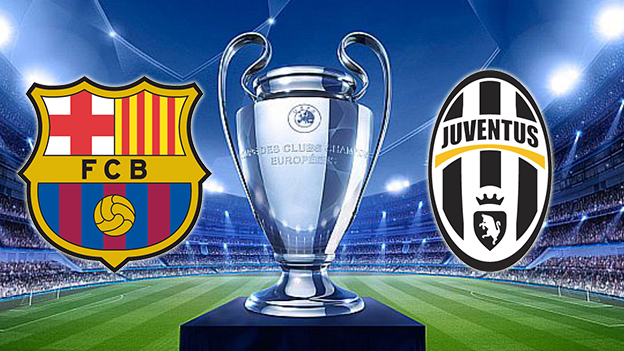

In [1]:
from IPython.display import Image
Image('http://worldcup2015livestreaming.com/wp-content/uploads/2015/06/Barcelona-vs-Juventus-UEFA-Final-2015.jpg')

The following is a brief data exploration of tweets about the UEFA Champions League Final 2015 between FC Barcelona and Juventus Turin.

The tweets were collected using a [twitter stream listener](https://github.com/neocortex/twitter-stream) based on [tweepy](http://www.tweepy.org/), which saves tweets in  a [mongoDB](https://www.mongodb.org/) database. The twitter stream was set up to listen to tweets containing at least one of the following terms: 

- championsleaguefinal
- cl
- barcelonavsjuventus
- barca
- juve
- barcajuve
- uclfinal
- juvefcb
- juvebarca

The stream listener was started around 5 minutes before kick-off and was stopped around 20 minutes after the final whistle.

In [2]:
# This command can be ignored. It is just a way to preven the output of annoying warnings in this IPython notebook.
import warnings
warnings.filterwarnings('ignore')

### Loading and preparing the data

First of all, we need to load the data from the mongoDB database. I stored all tweets in a collection called **tweets** in a database called **cl** (for Champions League). We use [pymongo](http://api.mongodb.org/python/current/) to make the connection to the mongoDB database, and [pandas](http://pandas.pydata.org/) to load the data into a DataFrame.

In [3]:
import pandas as pd
from pymongo import MongoClient

# Get the mongoDB collection
db = MongoClient().cl
collection = db.tweets

# Load each document (tweet) in the collection into a pandas DataFrame
df = pd.DataFrame([x for x in collection.find()])

Let's have a first look at what our data actually entails by looking at the first 10 tweets:

In [4]:
df.head(10)

,_id,coordinates,created_at,source,text
0,55733f9f3defaf33731ffd24,None,2015-06-06 18:44:46,Twitter for Android,@DjMaRiiO_90 Yo digo que hoy el barça pierde g...
1,55733f9f3defaf33731ffd25,None,2015-06-06 18:44:46,Twitter for Android,Match time!!! Barca to win 2 nil
2,55733f9f3defaf33731ffd26,None,2015-06-06 18:44:46,Twitter for iPhone,RT @sopitas: Alineaciones oficiales para la #U...
3,55733f9f3defaf33731ffd27,None,2015-06-06 18:44:46,Twitter for Android,RT @FCBarcelona_es: Se está celebrando la cere...
4,55733f9f3defaf33731ffd28,None,2015-06-06 18:44:46,Twitter for Android,Juve midfield is jus crazy
5,55733f9f3defaf33731ffd29,None,2015-06-06 18:44:46,Twitter Web Client,O değilde Lionel Messi hitlere benzemiş :D ber...
6,55733f9f3defaf33731ffd2a,None,2015-06-06 18:44:46,Periscope.TV,EN DIRECTO en #Periscope: UCLfinal https://t....
7,55733f9f3defaf33731ffd2b,None,2015-06-06 18:44:46,Twitter for Android Tablets,"RT @IvoSilvero: Que presentacion, que adrenali..."
8,55733f9f3defaf33731ffd2c,None,2015-06-06 18:44:46,Twitter for iPhone,#BarçaJuve #ChampionsLeagueFinal http://t.co/Z...
9,55733f9f3defaf33731ffd2d,None,2015-06-06 18:44:46,Twitter for Android,Dalhe Barçaaaa! @FCBarcelona \n#UCLfinal


We see that each row on the DataFrame, i.e. each tweet, consists of an ID, the coordinates of the tweet's origin, the time the tweet was created, the source of the tweet, and the actual text of the tweet.

The ID of each tweet is not of interest to us, an thus can be dropped. Moreover we can use the time column (*created_at*) as the index of our DataFrame:

In [5]:
df = df.set_index(df.created_at)
df = df.drop(['_id', 'created_at'], axis=1)

The datetimes in the DataFrame are in the [UTC](https://en.wikipedia.org/wiki/Coordinated_Universal_Time) time standard, but we actually want them in the local timezone (the game took place in Berlin), which is [CEST](https://en.wikipedia.org/wiki/Central_European_Summer_Time). To do so, I map a function that does the conversion from UTC to CEST (using [pytz](http://pytz.sourceforge.net/) to every entry in the DataFrame's index:

In [6]:
from pytz import timezone, utc

def utc2mest(date):
    mest = timezone('Europe/Berlin')
    utc_time = utc.localize(date)
    return utc_time.astimezone(mest)

df.index = df.index.map(utc2mest)

Finally, in order to start and end with a complete minute, I am going to use only tweets that were created between 20:45:00 and 20:50:59:

In [7]:
from datetime import datetime

from_time = datetime(2015, 06, 06, 20, 45)
to_time = datetime(2015, 06, 06, 22, 51)

df = df[df.index >= from_time]
df = df[df.index < to_time]

Now that we have prepared the data, we can take another look at our DataFrame:

In [8]:
df.head(10)

,coordinates,source,text
2015-06-06 20:45:00+02:00,None,Twitter for iPhone,HYPE AF LETS GO BARCA!!!
2015-06-06 20:45:00+02:00,None,Twitter for iPhone,Forza Juve
2015-06-06 20:45:00+02:00,None,Twitter for Android,RT @DiarioOle: #ChampionsLeagueFinal Previa | ...
2015-06-06 20:45:00+02:00,None,Twitter for Android,RT @Gauyo: No hay nada tan parecido a un Mundi...
2015-06-06 20:45:00+02:00,None,Twitter for Android,#VisçaBarça a por la 5ta &amp; la cuarta que Y...
2015-06-06 20:45:00+02:00,None,Twitter for Android,"Ni juve, ni barca. Que gane el mejor y ya."
2015-06-06 20:45:00+02:00,None,Twitter Web Client,@MattHDGamer Barca for me 3-2 after extra time
2015-06-06 20:45:00+02:00,None,Twitter for Android,RT @Heineken: S.O.S.! Roberto Carlos signals f...
2015-06-06 20:45:00+02:00,None,Twitter for iPhone,Vamos barca #FCBarcelona !!!!!!!!!!!!
2015-06-06 20:45:00+02:00,None,Twitter for iPhone,RT @I_Zayy: باقي ٤٥ دقيقة ..\n\nيااااارب تنكتب...


We see that the index is now the time the tweet was create (in MEST timezone), and the tweet ID was dropped. We can take a look at total number of tweets in our dataset and verify that the all tweets were indeed created within the period specified above:

In [9]:
print 'Number of tweets: ', df.shape[0]
print 'From: ', df.index.min().time()
print 'To: ', df.index.max().time()

Number of tweets:  349926
From:  20:45:00
To:  22:50:59


AttributeError: Unknown property fs

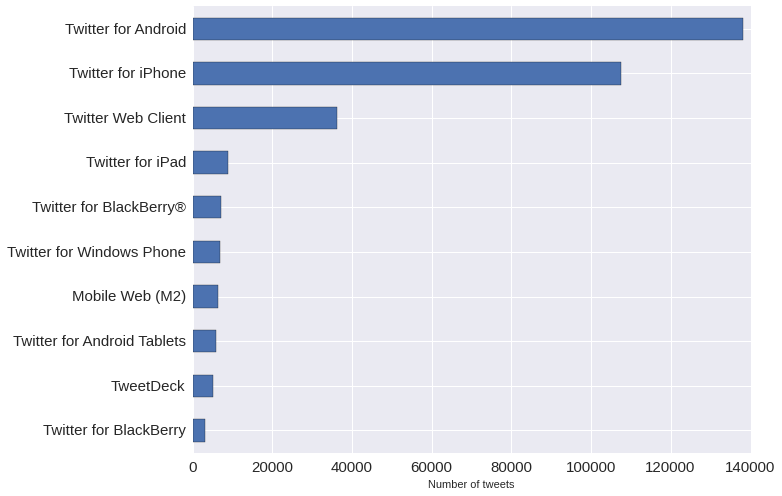

In [10]:
%matplotlib inline
import pylab as pl
import seaborn; seaborn.set()
pl.figure(figsize=(10, 8))
ax = df['source'].value_counts()[:10][::-1].plot(kind='barh', fontsize=15)
ax.set_xlabel('Number of tweets');

### Tweets per minute

In [11]:
from collections import defaultdict

In [12]:
tweets_per_minute = defaultdict(int)

In [13]:
for date in df.index:
    tweets_per_minute[(date.hour, date.minute)] += 1

In [14]:
time = []
counts = []
for key in sorted(tweets_per_minute):
    time.append(key)
    counts.append(tweets_per_minute[key])

In [15]:
times = ['{:02}:{:02}'.format(t[0], t[1]) for t in time]

In [16]:
time_labels = []
for i, t in enumerate(times):
    time_labels.append(t if (i % 5 == 0) else '')

In [17]:
import numpy as np

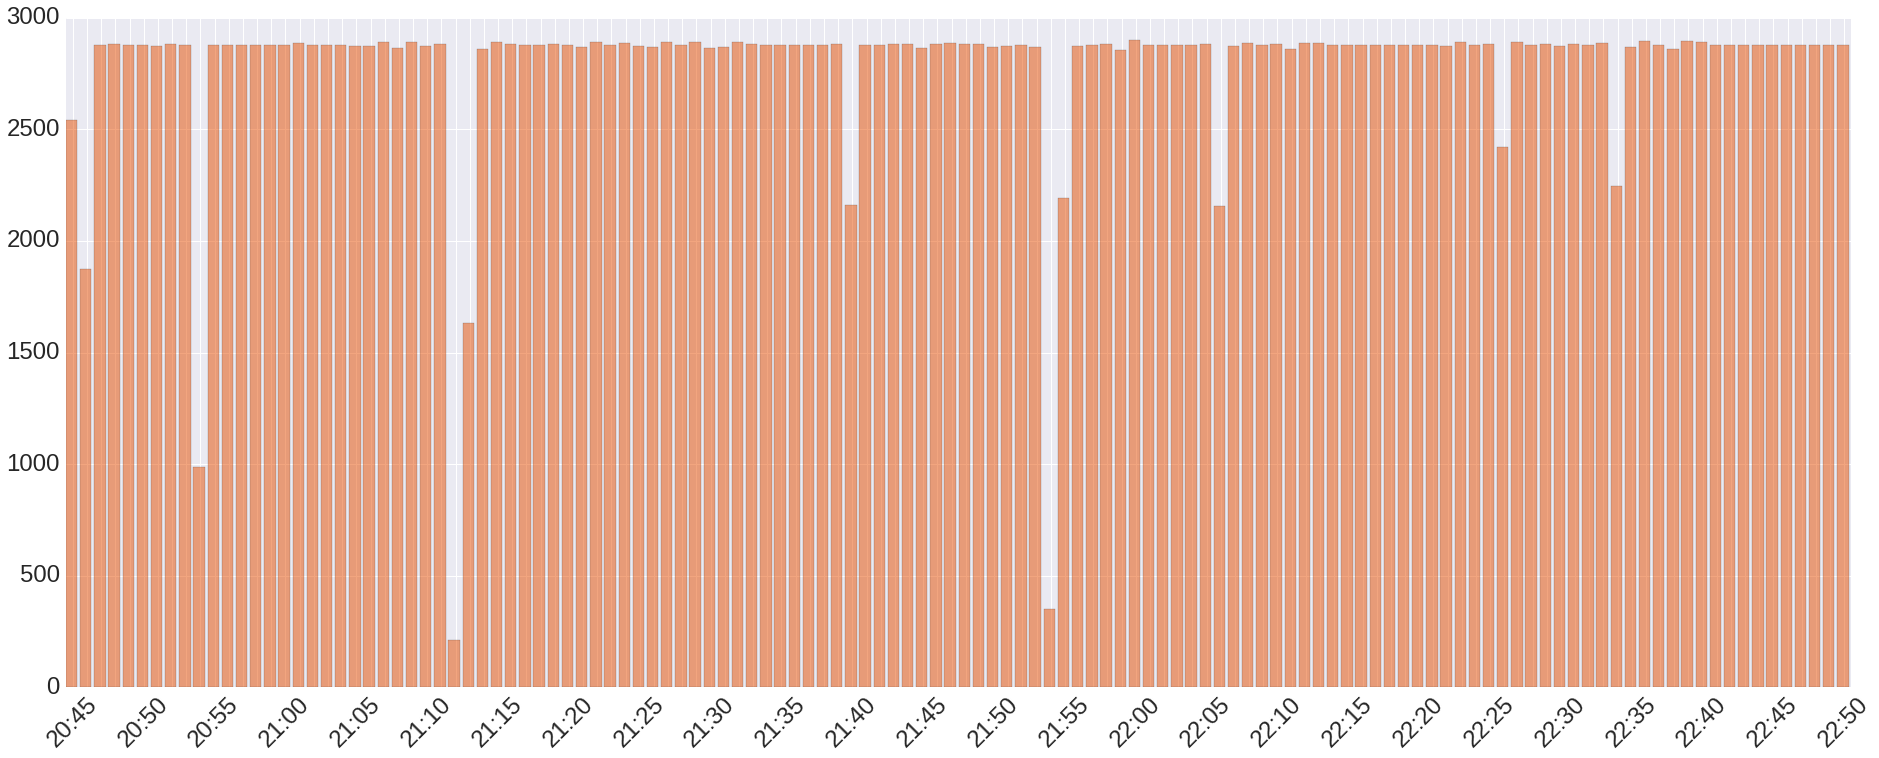

In [18]:
fig, ax = pl.subplots(1, figsize=(32, 12))
ax.bar(xrange(len(counts)), counts, color=(.9, .3, .0), alpha=.5);
ax.set_xticks(np.arange(len(counts)) + .5)
ax.set_xticklabels(time_labels, rotation=45)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlim([0, len(counts)]);

### Goals?

In [19]:
goals_per_minute = defaultdict(int)
for idx in xrange(len(df)):
    if 'goal' in df.iloc[idx].text.lower() or 'gol' in df.iloc[idx].text.lower():
        date = df.index[idx]
        goals_per_minute[(date.hour, date.minute)] += 1

In [20]:
goal_time = []
goal_counts = []
for key in sorted(goals_per_minute):
    goal_time.append(key)
    goal_counts.append(goals_per_minute[key])
times = ['{:02}:{:02}'.format(t[0], t[1]) for t in time]

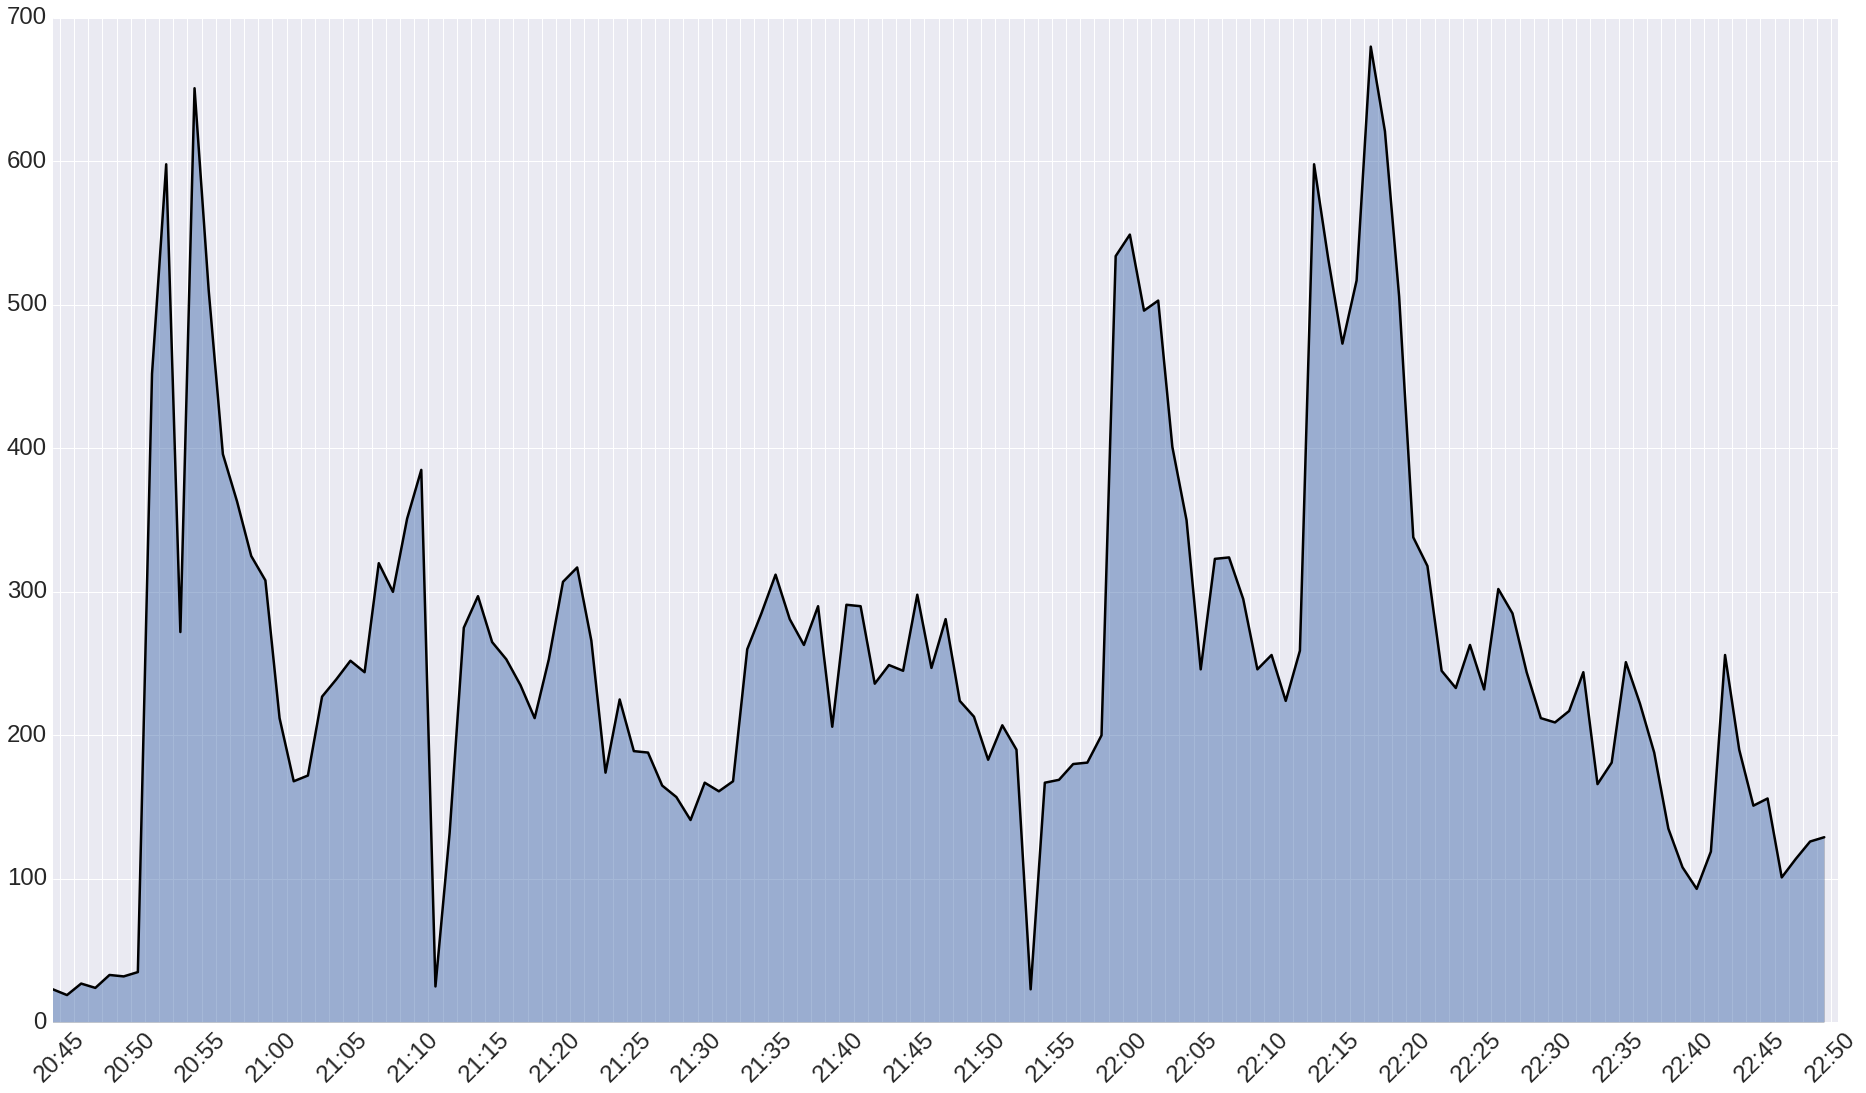

In [21]:
fig, ax = pl.subplots(1, figsize=(32, 18))
ax.plot(xrange(len(goal_counts)), goal_counts, lw=2.5, color='k')
ax.fill_between(xrange(len(goal_counts)), goal_counts, alpha=0.5)
ax.set_xticks(np.arange(len(goal_counts)) + .5)
ax.set_xticklabels(time_labels, rotation=45)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlim([0, len(goal_counts)]);

In [22]:
counts = np.asarray(counts)
goal_counts = np.asarray(goal_counts)
counts_norm = counts / float(counts.sum())
goal_counts_norm = goal_counts / float(goal_counts.sum())

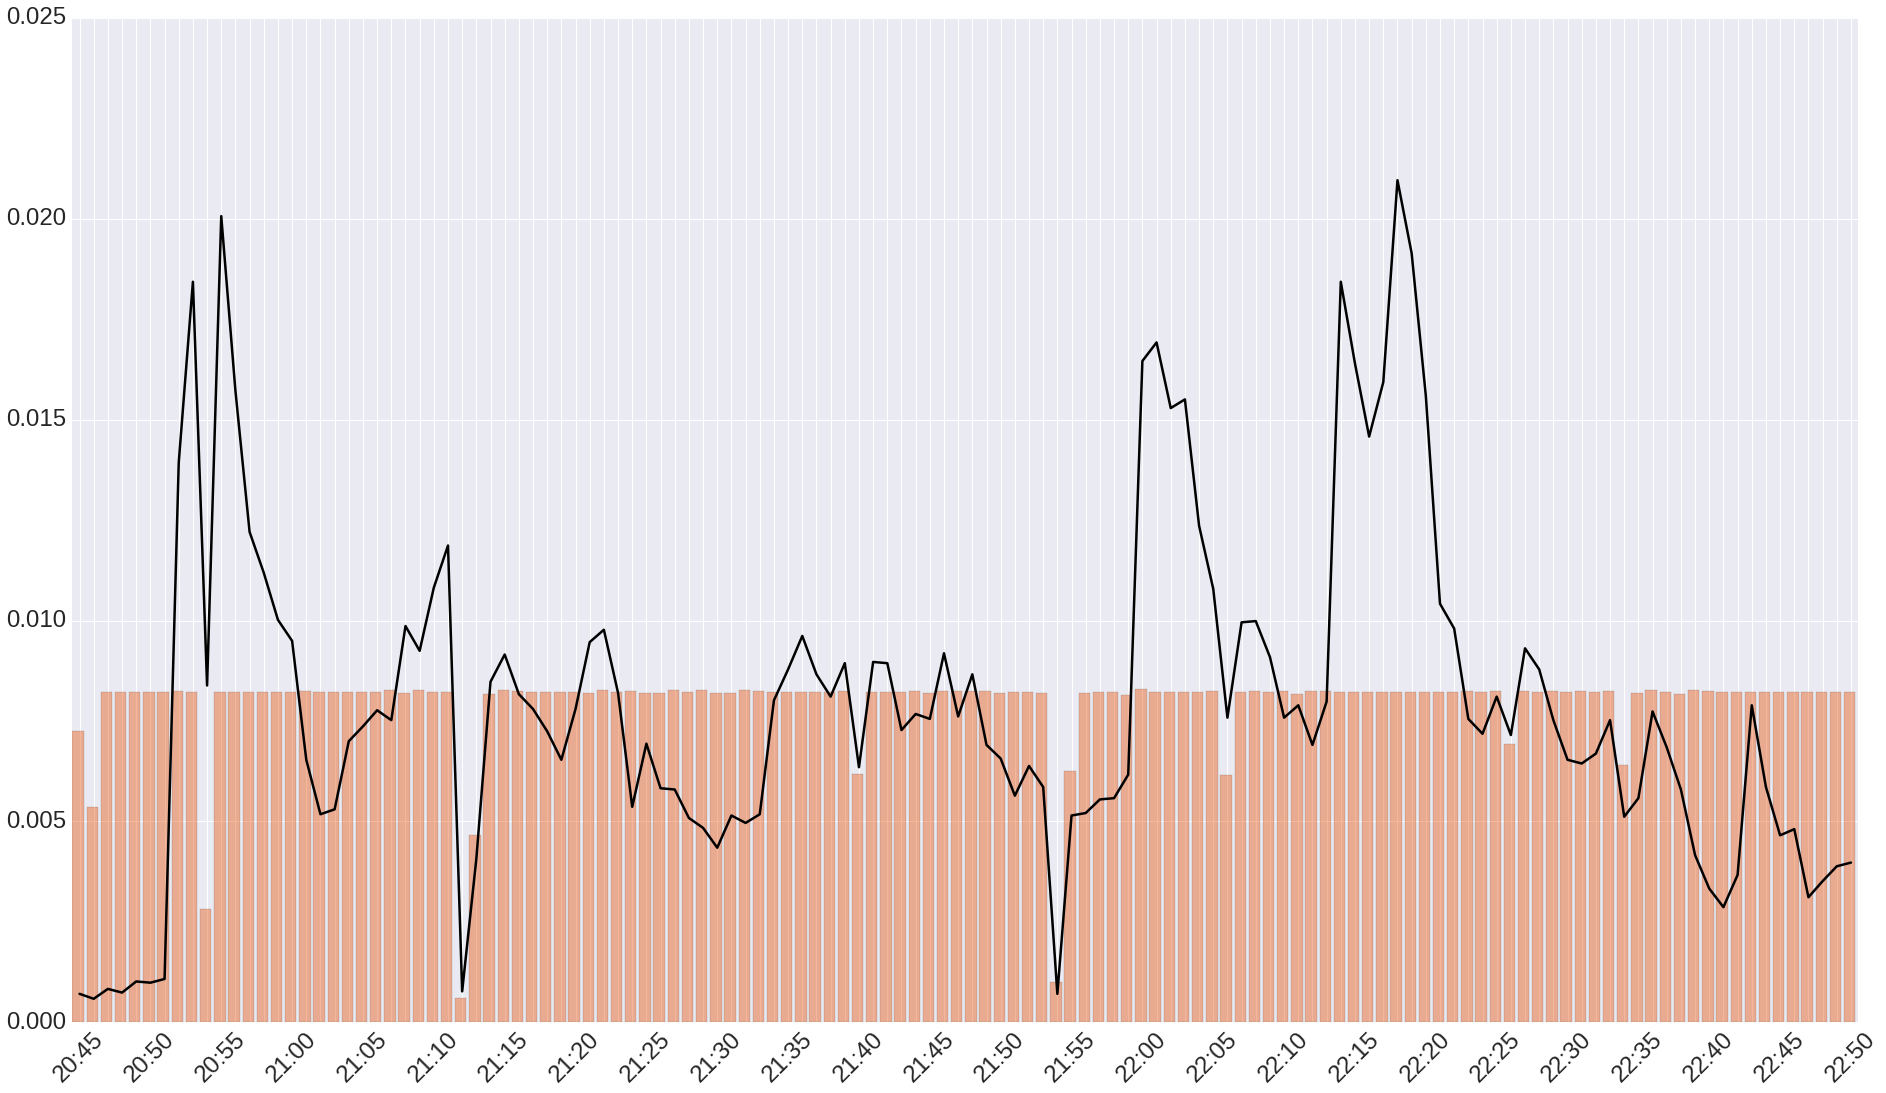

In [23]:
fig, ax = pl.subplots(1, figsize=(32, 18))
ax.bar(xrange(len(counts_norm)), counts_norm, color=(.9, .3, .0), alpha=.4)
ax.plot(np.arange(len(goal_counts_norm)) + .5, goal_counts_norm, lw=2.5, color='k')
ax.set_xticks(np.arange(len(goal_counts)) + .5)
ax.set_xticklabels(time_labels, rotation=45)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlim([0, len(goal_counts)]);

In [24]:
rel_goals = goal_counts / counts.astype('float')

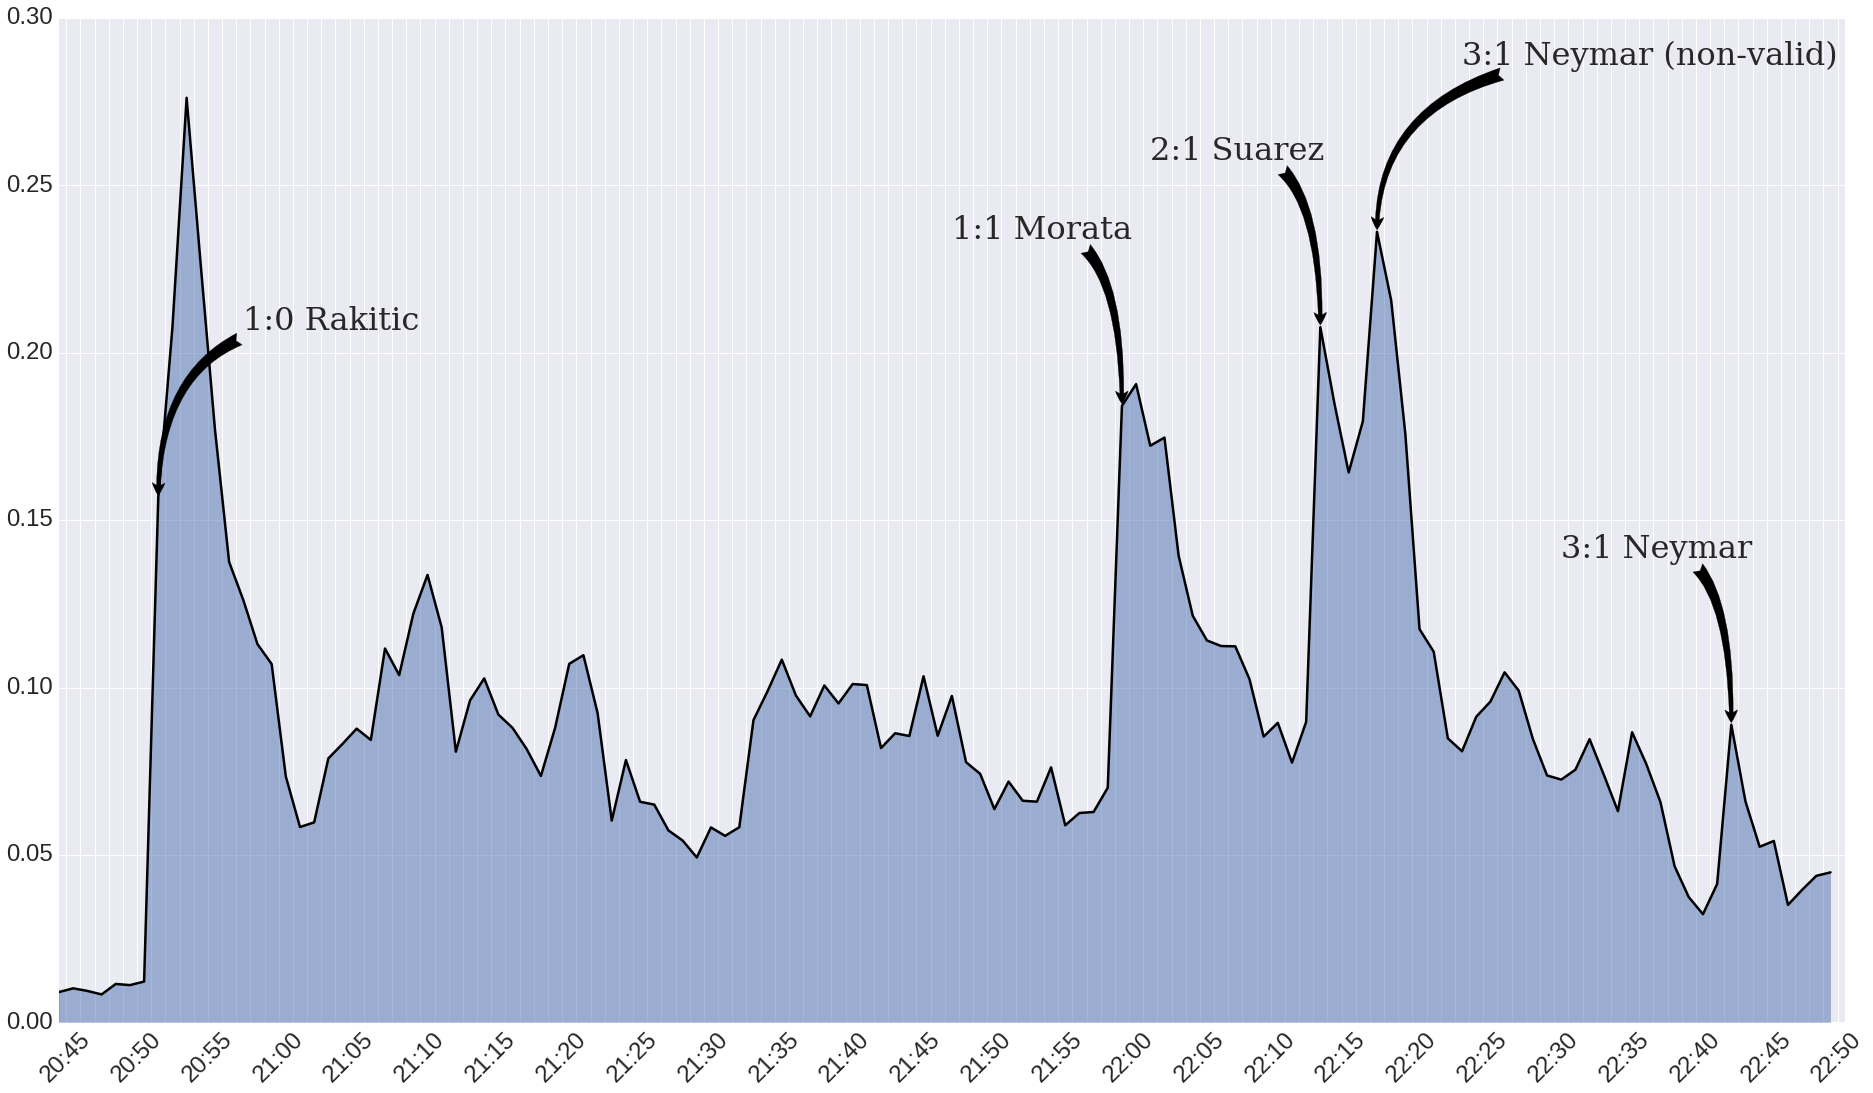

In [25]:
fig, ax = pl.subplots(1, figsize=(32, 18))
ax.plot(xrange(len(goal_counts)), rel_goals, lw=2.5, color='k')
ax.set_xticks(np.arange(len(goal_counts)) + .5)
ax.set_xticklabels(time_labels, rotation=45)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlim([0, len(goal_counts)])
ax.fill_between(xrange(len(goal_counts)), rel_goals, alpha=0.5)
from collections import OrderedDict
goals = OrderedDict([('1:0 Rakitic', '20:52'), ('1:1 Morata', '22:00'), ('2:1 Suarez', '22:14'),
                     ('3:1 Neymar (non-valid)', '22:18'), ('3:1 Neymar', '22:43')])
i = 3
for goal, time in goals.iteritems():
    x = times.index(time)
    y = rel_goals[x]
    xpos = x + 6 if (i % 3 == 0) else x - 12
    ax.annotate(goal, xy=(x, y), xytext=(xpos, y+0.05), size=32, fontname='serif',
            arrowprops=dict(arrowstyle="fancy", facecolor='black', connectionstyle="angle3,angleA=0,angleB=-90"),
            )
    i += 1

### Madrid?

In [26]:
madrid_per_minute = defaultdict(int)
for idx in xrange(len(df)):
    if 'real' in df.iloc[idx].text.lower() or 'madrid' in df.iloc[idx].text.lower():
        date = df.index[idx]
        madrid_per_minute[(date.hour, date.minute)] += 1

In [27]:
madrid_time = []
madrid_counts = []
for key in sorted(madrid_per_minute):
    madrid_time.append(key)
    madrid_counts.append(madrid_per_minute[key])

In [28]:
rel_madrid = madrid_counts / counts.astype('float')
rel_madrid /= rel_madrid.sum()

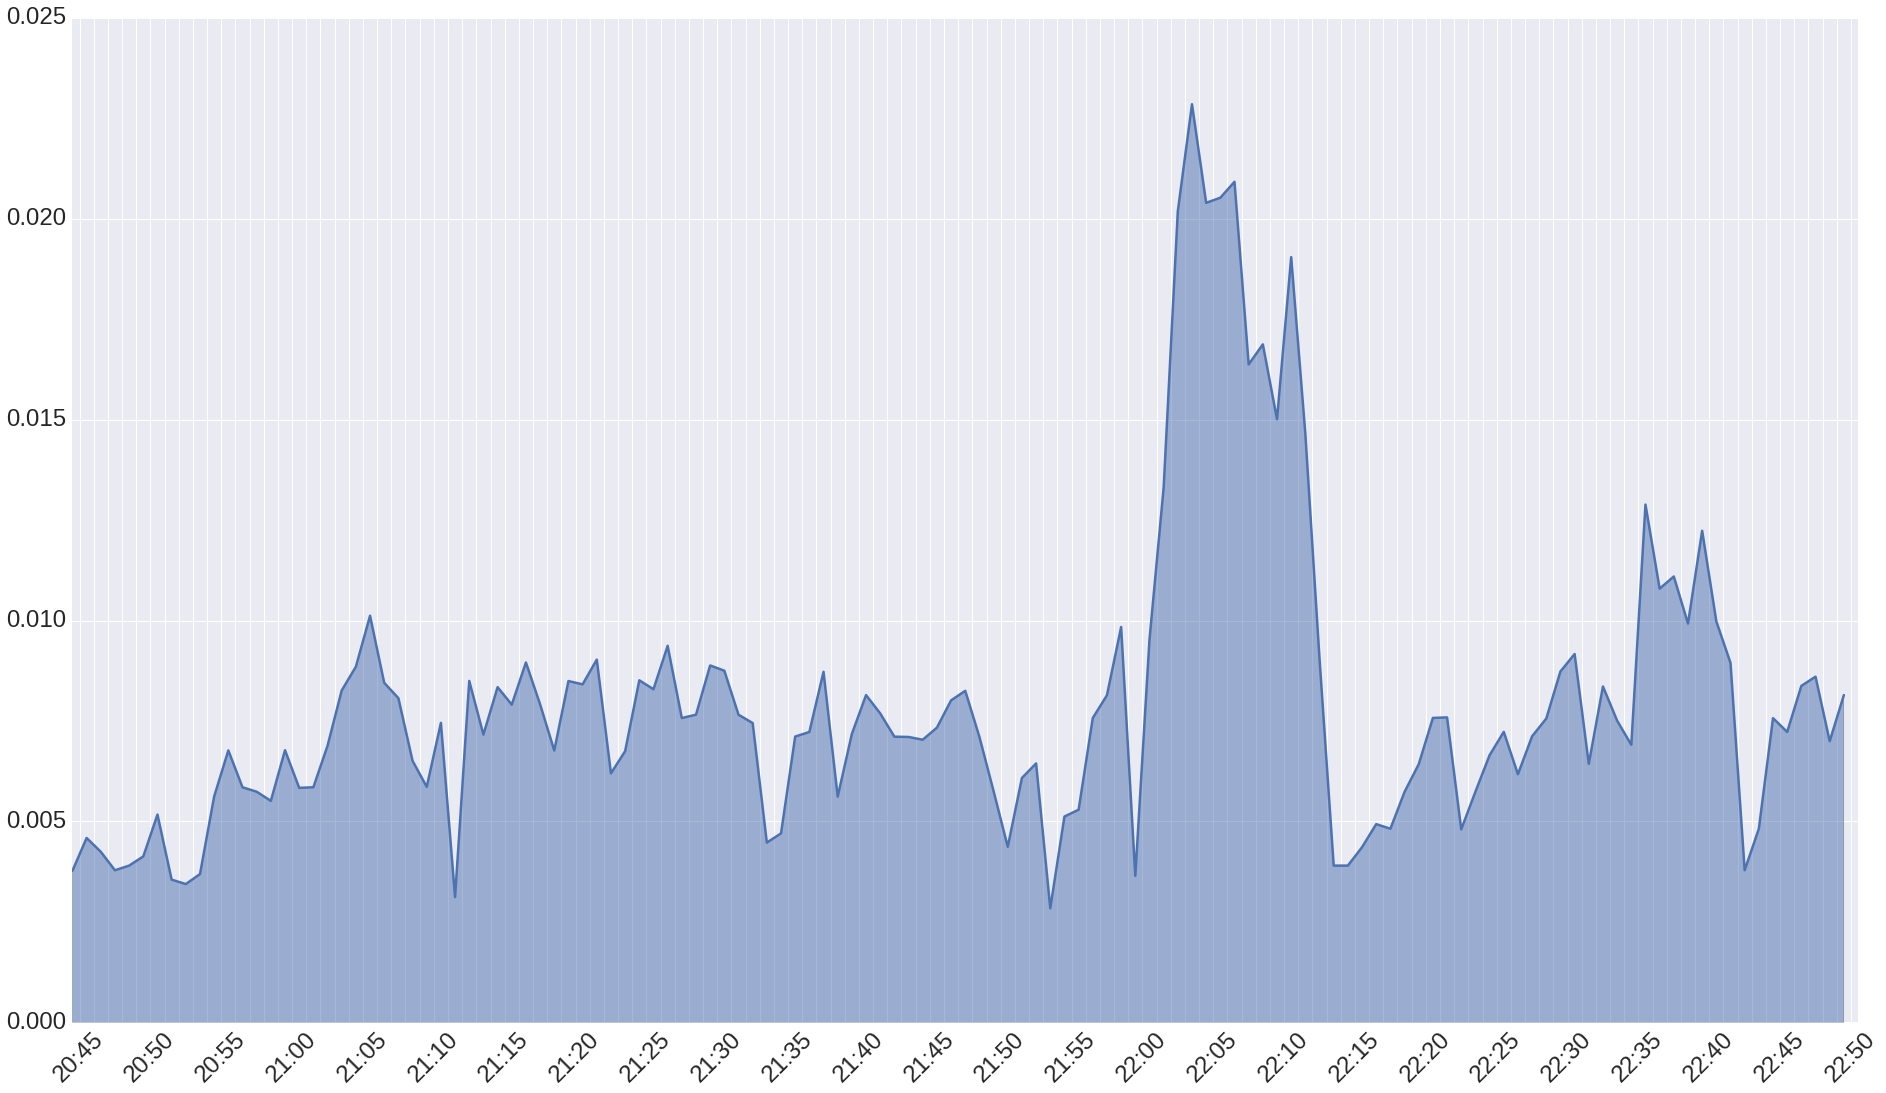

In [29]:
fig, ax = pl.subplots(1, figsize=(32, 18))
ax.plot(xrange(len(goal_counts)), rel_madrid, lw=2.5)
ax.fill_between(xrange(len(goal_counts)), rel_madrid, alpha=0.5)
ax.set_xticks(np.arange(len(goal_counts)) + .5)
ax.set_xticklabels(time_labels, rotation=45)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlim([0, len(goal_counts)]);

In [30]:
goals_times_madrid = rel_madrid * rel_goals

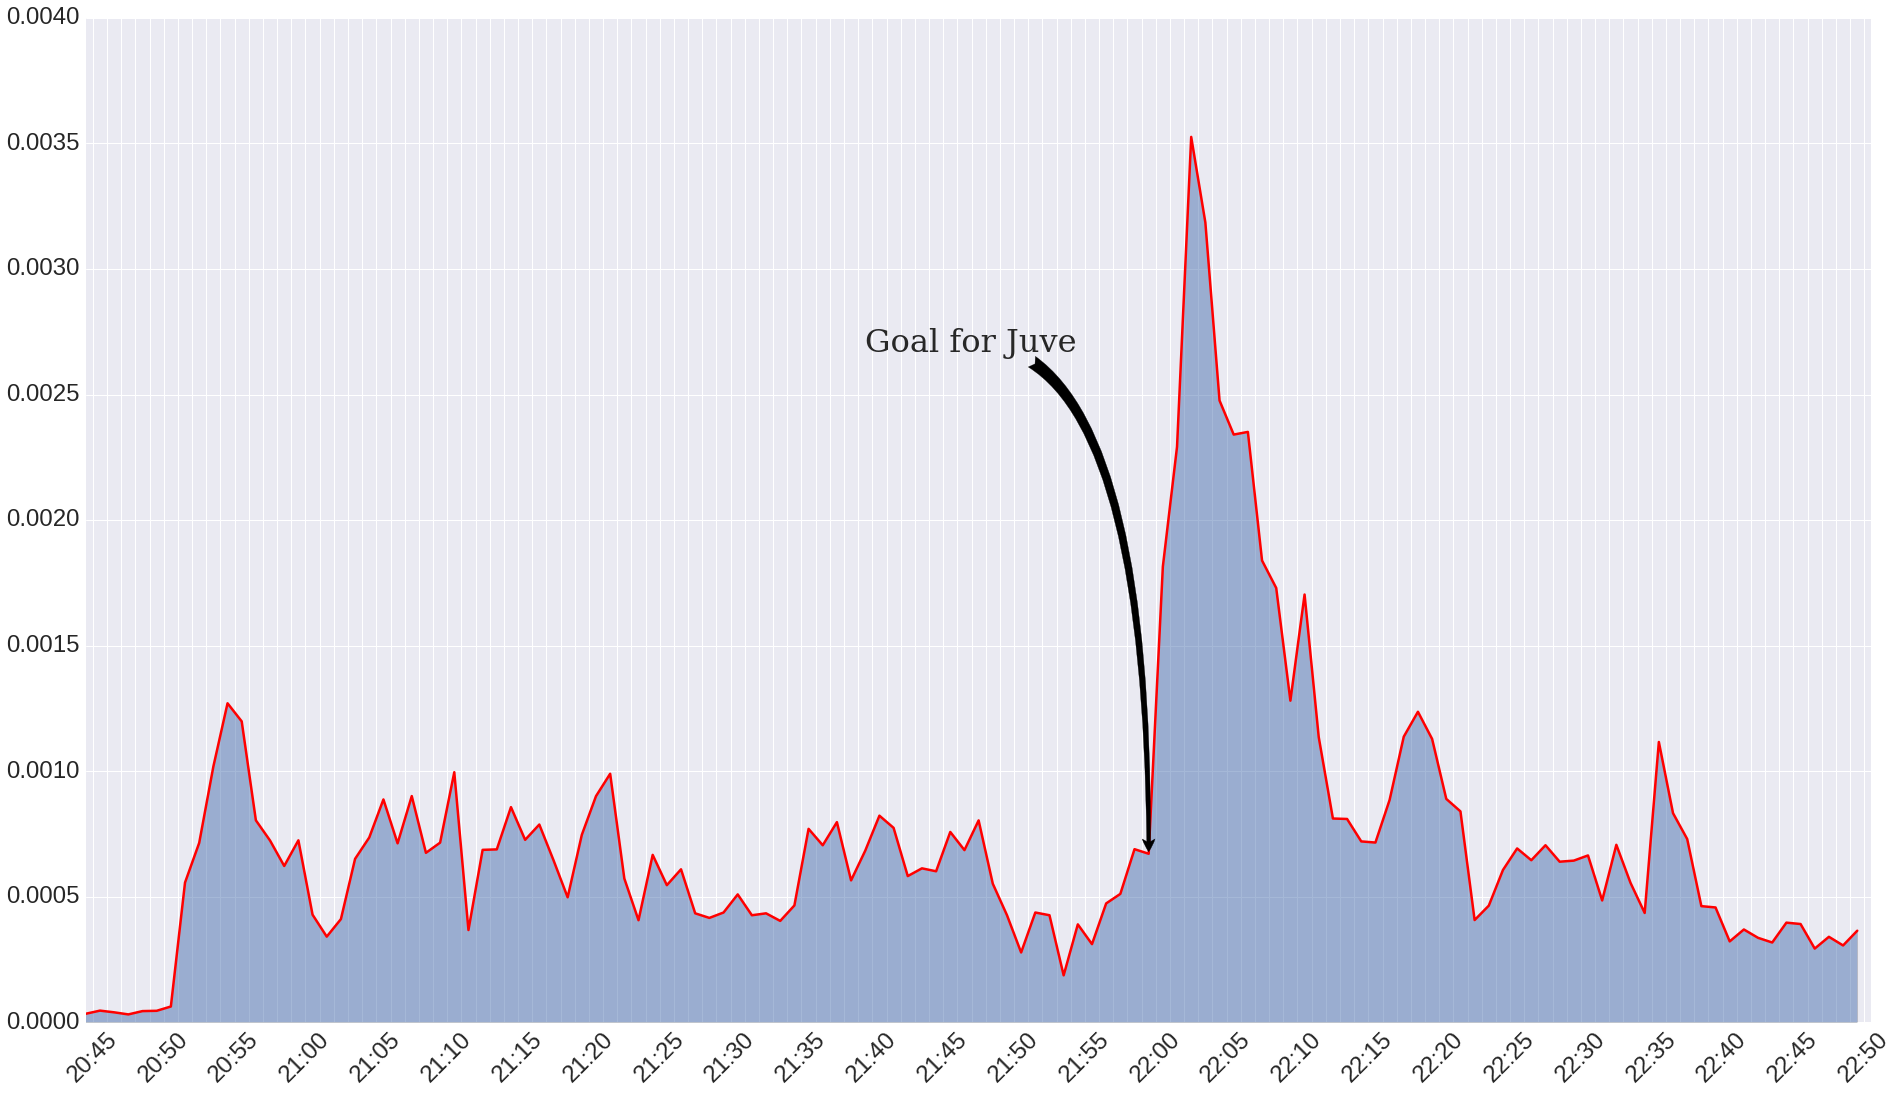

In [31]:
fig, ax = pl.subplots(1, figsize=(32, 18))
ax.plot(xrange(len(goal_counts)), goals_times_madrid, lw=2.5, color='r')
ax.fill_between(xrange(len(goal_counts)), goals_times_madrid, alpha=0.5)
ax.set_xticks(np.arange(len(goal_counts)) + .5)
ax.set_xticklabels(time_labels, rotation=45)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlim([0, len(goal_counts)])
x = times.index('22:00')
y = goals_times_madrid[x]
ax.annotate('Goal for Juve', xy=(x, y), xytext=(x-20, y+0.002), size=32, fontname='serif',
            arrowprops=dict(arrowstyle="fancy", facecolor='black', connectionstyle="angle3,angleA=0,angleB=-90"))

### Words

In [32]:
texts = [t for t in df.text]
text = ' '.join(texts)

In [33]:
import nltk

In [34]:
nltk.download()

showing info http://www.nltk.org/nltk_data/


True

In [35]:
nltk.data.path = ['/home/rafael/.nltk_data']
words = nltk.word_tokenize(text)

In [36]:
import string
exclude = set(string.punctuation)
cleaned = [''.join(ch for ch in s if ch not in exclude).lower() for s in words]

In [37]:
from nltk.corpus import stopwords
stwords = stopwords.words('english') + stopwords.words('spanish') + stopwords.words('italian')

In [38]:
words = [word for word in cleaned if len(word) > 1 and 'http' not in word
                                and not word.startswith('@')
                                and word != 'rt' and word not in stwords]

In [39]:
from wordcloud import WordCloud, STOPWORDS

In [40]:
from PIL import Image

In [41]:
cup_mask = Image.open('cup_mask2.png')
cup_mask = cup_mask.convert('L')
wc = WordCloud(background_color="black", max_words=1000, mask=np.asarray(cup_mask))
wc.generate(' '.join(words));

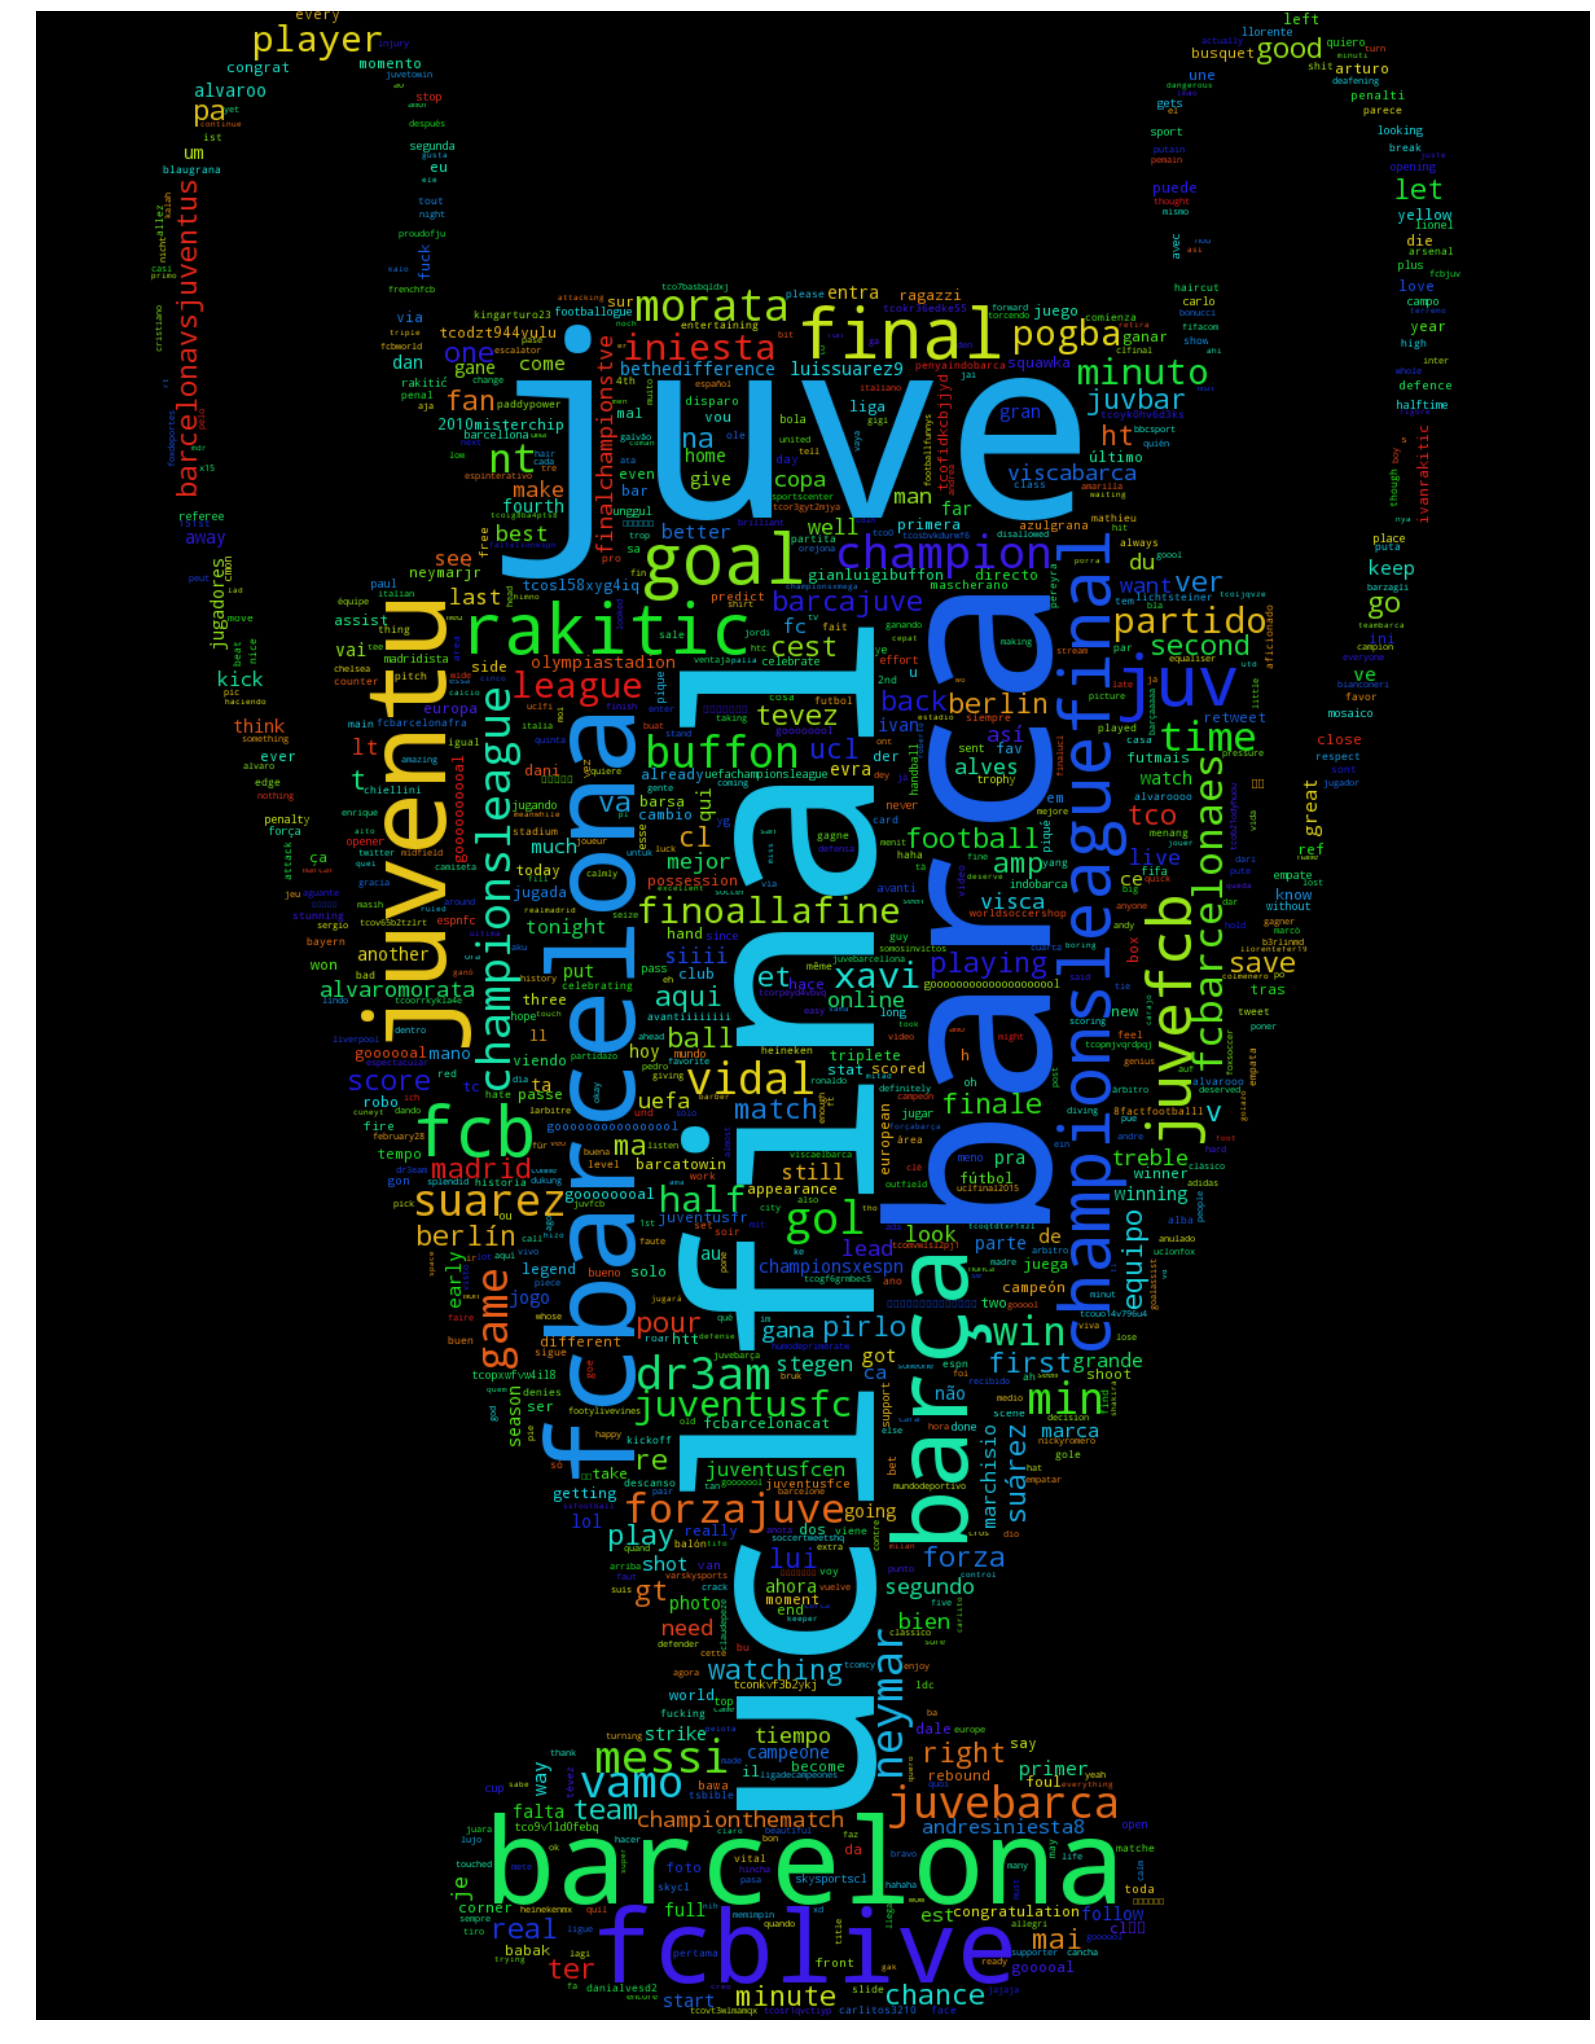

In [42]:
pl.figure(figsize=(64, 36))
pl.imshow(wc)
pl.axis("off");